In [45]:
import pandas as pd
import numpy as np

In [46]:
# title budget genres country main_charactor director vote_average vote_count
df = pd.concat([pd.read_csv('data/movie_genres_data.csv'), pd.read_csv('data/movie_data_ID.csv')], axis=1)

In [47]:
# heatmap의 상관관계 있는 장르만 사용해보자
# 액션, 모험, 판타지 sf, 드라마 공포, 스릴러, 범죄, 로맨스
df = df.drop(['Family','Animation','Comedy','History','TV Movie','War','Documentary','Western', 'Mystery'], axis=1)

In [48]:
# 로지스틱 회귀 모델(sigmoid) : weight초기화, dropout, ReLU, batch nomalization
# 결과 : 흥행성공, 흥행 실패, 전체영화 의 평균 정확도
# 1. 데이터셋 준비하기
df.drop(['genres', 'country', 'vote_score', 'vote_count'], axis=1, inplace=True)
df.vote_weight = df.vote_weight.apply(lambda x: 1 if x >= 11 else 0)

In [49]:
df.budget = df.budget / df.budget.max()
df.charactor = df.charactor / df.charactor.max()
df.director = df.director / df.director.max()

In [50]:
df.to_csv('data/movie_data_ML_op.csv', index=False)

In [51]:
df.drop(['title'], axis=1, inplace=True)

In [52]:
X = np.array(df)

In [53]:
# y_train : 흥행했는지(1) 안했는지(0)
from sklearn.model_selection import train_test_split
y = X[:, 13:]
X = X[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_val = X_test[:513]
y_val = y_test[:513]

In [54]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4102, 13)
(4102, 1)
(513, 13)
(513, 1)
(1026, 13)
(1026, 1)


- 모델 구성 및 분석

In [55]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams.update({'text.color': "black",
                    'axes.labelcolor': "white",
                     'xtick.color': "white",
                     'ytick.color': "white"
                     })

Epoch 1/50
129/129 [==============================] - 2s 7ms/step - loss: 0.6837 - accuracy: 0.5953 - val_loss: 0.6745 - val_accuracy: 0.6238
Epoch 2/50
129/129 [==============================] - 1s 4ms/step - loss: 0.6579 - accuracy: 0.6533 - val_loss: 0.6507 - val_accuracy: 0.6550
Epoch 3/50
129/129 [==============================] - 1s 4ms/step - loss: 0.6347 - accuracy: 0.6738 - val_loss: 0.6292 - val_accuracy: 0.6686
Epoch 4/50
129/129 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6892 - val_loss: 0.6181 - val_accuracy: 0.6589
Epoch 5/50
129/129 [==============================] - 1s 5ms/step - loss: 0.6045 - accuracy: 0.6880 - val_loss: 0.6091 - val_accuracy: 0.6569
Epoch 6/50
129/129 [==============================] - 1s 4ms/step - loss: 0.5971 - accuracy: 0.6882 - val_loss: 0.6009 - val_accuracy: 0.6745
Epoch 7/50
129/129 [==============================] - 0s 4ms/step - loss: 0.5922 - accuracy: 0.6906 - val_loss: 0.5990 - val_accuracy: 0.6686
Epoch 

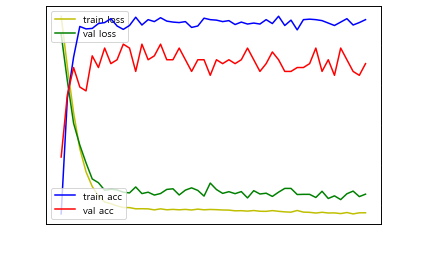

In [56]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
model = Sequential()
# 1. 과적합 : train acc 85%, test acc 65% => Node수와 Hidden Layer수를 줄여야함
#model.add(Dense(64, activation='relu', input_dim=22))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(64, activation='relu'))

# 2. Dense의 한계치 : test acc 68% => 다른 모델을 사용해야함, L2 Regularization : test acc 69%
#model.add(Dense(32, activation='relu', input_dim=22))
#model.add(Dense(1, activation='sigmoid'))

# Dropout 68.5%
model.add(Dense(32, activation='relu', input_dim=13))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train, y_train, epochs=50, batch_size=32,
                 validation_data=(X_val, y_val))

loss_and_metrics = model.evaluate(X_test, y_test, batch_size=32)
print('손실 :', loss_and_metrics[0])
print('정확도 :', loss_and_metrics[1] * 100, '%')
print("-" * 20)

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'r', label='val acc')

loss_ax.set_xlabel('epoch')

loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [57]:
yhat = model.predict(X_test)
for i in range(10):
    print(1 if yhat[i] > 0.5 else 0, end=" ")
print()
for i in y_test[:10]:
    print(int(*i), end=" ")

33/33 [==============================] - 0s 2ms/step
0 1 1 1 1 1 1 1 0 1 
1 1 0 1 0 1 1 0 0 1 

In [58]:
model.save('model/Dense_Dropout.h5')

In [59]:
# tensorflow.js 용
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'model/Dense_Dropout_js')